In [195]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader




# Add custom module path
module_path = os.path.abspath(os.path.join('scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from helper_functions import extract_spectrograms

# IRIS client instance
client = Client('IRIS')

from typing import Any

from scipy.signal import correlate




In [196]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_3776147/2645211226.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', 

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [197]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:56.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:51.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:07:29.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:29:40.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:11:46.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:11:49.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:48:28.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [198]:
event = exotic.iloc[3]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3177488
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SUG
station_location_code                              --
station_latitude_deg                           46.215
station_longitude_deg                        -122.176
station_elevation_m                            1864.0
trace_name                        bucket1$5,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-12-06T23:48:51.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                       5.281|8.824|18.920
Name: 360, dtype: object


## Local version

In [216]:
# defining the constants
# amount of tapering
taper_alpha = 0.1
# filter parameters
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
lowcut = 1
highcut = 20
fs = 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients





## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)




orig_s = np.array(s)



# detrending
s.detrend(type = 'linear')


# resampling
s.resample(50)



# this contains detrended data
detrended_data_local = np.array(s)



# event data
event_data = np.array(s)

# tapering before filtering
taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
tapered_data = np.array([np.multiply(taper, row) for row in event_data])


#Apply bandpass filtering
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





# resampling and normalizing 
num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

resampled_data = resampled_data[:,0:5000]
resampled_data = resampled_data.reshape(1,3, 5000)

mmax = np.std(np.abs(resampled_data[0]))
norm = resampled_data/mmax



In [217]:
lowcut = 1
highcut = 20
fs = 50


def linear_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Apply linear detrending similar to ObsPy.
    """
    # Time indices
    time = torch.arange(tensor.shape[-1], dtype=tensor.dtype, device=tensor.device)

    # Calculate linear fit coefficients using least squares
    time_mean = time.mean()
    time_variance = ((time - time_mean) ** 2).sum()
    slope = ((tensor * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_variance
    intercept = tensor.mean(dim=-1, keepdim=True) - slope * time_mean

    # Compute the trend
    trend = slope * time + intercept

    # Remove the trend from the original tensor
    return tensor - trend



def exact_scipy_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Exact PyTorch equivalent of scipy.signal.detrend(type='linear').

    tensor shape: (C, T) or (B, C, T)
    """
    orig_shape = tensor.shape
    if tensor.ndim == 1:
        tensor = tensor.unsqueeze(0)  # (1, T)
    elif tensor.ndim == 3:
        tensor = tensor.view(-1, tensor.shape[-1])  # (B*C, T)
    
    N, T = tensor.shape
    t = torch.arange(T, dtype=tensor.dtype, device=tensor.device).unsqueeze(0).expand(N, -1)  # (N, T)

    ones = torch.ones_like(t)
    A = torch.stack([t, ones], dim=1).transpose(1, 2)  # shape: (N, T, 2)

    # Least squares: (A^T A)^-1 A^T y
    A_T = A.transpose(1, 2)  # (N, 2, T)
    coeffs = torch.linalg.lstsq(A, tensor.unsqueeze(-1)).solution.squeeze(-1)  # (N, 2)

    slope = coeffs[:, 0].unsqueeze(1)  # (N, 1)
    intercept = coeffs[:, 1].unsqueeze(1)  # (N, 1)

    trend = slope * t + intercept  # (N, T)
    detrended = tensor - trend

    return detrended.view(orig_shape)




# Apply the filter using filtfilt
def bandpass_filter(batch: torch.Tensor, fs: float, lowcut: float, highcut: float, order = 4) -> torch.Tensor:
    # Convert tensor to numpy array
    input_numpy = batch.numpy()  # Shape: (batch_size, num_channels, window_length)

    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b,a  = butter(order, [low, high], btype = 'band')

    # Apply the bandpass filter to each batch and each channel
    filtered_numpy = np.zeros_like(input_numpy)
    for i in range(input_numpy.shape[0]):  # Iterate over batch size
        for j in range(input_numpy.shape[1]):  # Iterate over channels
            filtered_numpy[i, j, :] = filtfilt(b, a, input_numpy[i, j, :])

    # Convert back to tensor
    filtered_tensor = torch.tensor(filtered_numpy)
    return filtered_tensor



def normalize_per_trace_globally(batch: torch.Tensor) -> torch.Tensor:
    """
    Normalize each trace (across all 3 components) using a single std,
    exactly like the NumPy version that does:
    norm = resampled_data / np.std(np.abs(resampled_data[0]))
    
    Input shape:  (B, 3, T)
    Output shape: (B, 3, T)
    """
    batch_abs = torch.abs(batch)                     # (B, 3, T)
    stds = batch_abs.view(batch.shape[0], -1).std(dim=1, keepdim=True)  # (B, 1)
    stds = stds.view(-1, 1, 1)                        # reshape to broadcast (B, 1, 1)
    return batch / (stds + 1e-10)



In [218]:
## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)






# resample to 50 Hz
s.resample(50)



# converting into array
event_data = np.array(s)[:, :5000]

# reshaping for shape compatibility
event_data = event_data.reshape(1, 3, 5000)

# converting into pytorch tensor. 
batch = torch.tensor(event_data, dtype=torch.float32)



# detrending
detrended_batch = linear_detrend(batch)



# tapering
device = 'cpu'
tukey_window = scipy.signal.windows.tukey(detrended_batch.shape[-1], alpha=0.1)

# Convert the Tukey window to a PyTorch tensor
taper = torch.tensor(tukey_window, device=batch.device)
        
# Apply the Tukey window to the batch
tapered_batch = detrended_batch * taper  # Broadcasting over last axis
    


    
# filtering 
filtered_batch = bandpass_filter(tapered_batch, fs, lowcut, highcut)



norm_batch = normalize_per_trace_globally(filtered_batch)

"""
# Normalize each component by the standard deviation of their absolute values
batch_abs = torch.abs(filtered_batch)
std_abs = batch_abs.std(dim=-1, keepdim=True)
norm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero
"""

'\n# Normalize each component by the standard deviation of their absolute values\nbatch_abs = torch.abs(filtered_batch)\nstd_abs = batch_abs.std(dim=-1, keepdim=True)\nnorm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero\n'

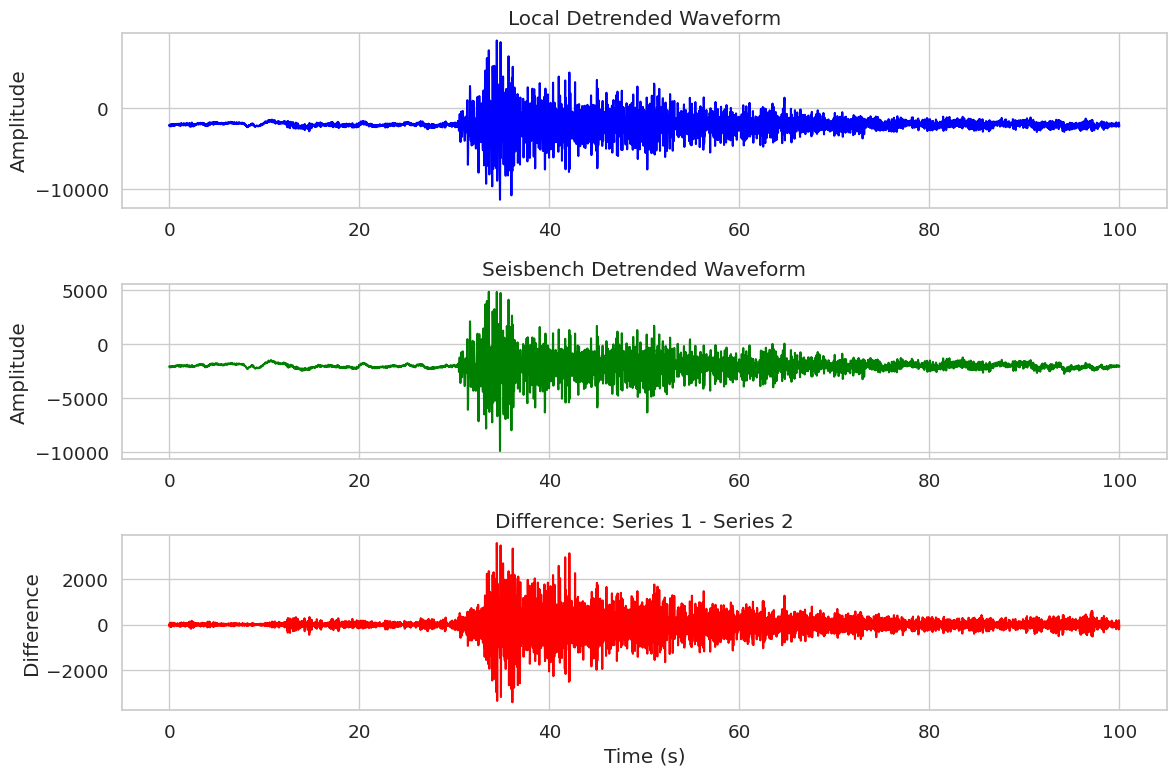

In [219]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = orig_s[2][0:5000]
series2 = batch[0][2].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
#plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


In [208]:
s

3 Trace(s) in Stream:
CC.SUG..BHE | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples
CC.SUG..BHN | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples
CC.SUG..BHZ | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples

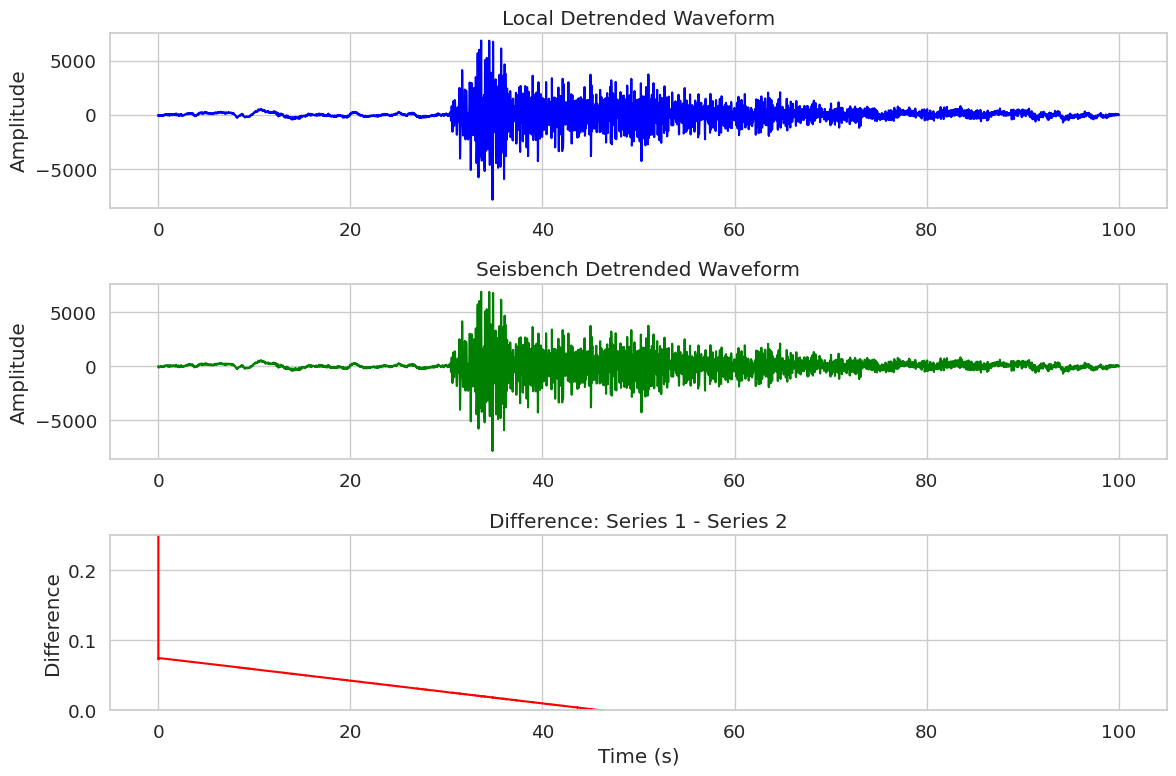

In [207]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = detrended_data_local[2][0:5000]
series2 = detrended_batch[0][2].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


In [204]:
series1

array([ -36.80237825, -131.7850106 ,  -98.48177889, ...,   64.04706947,
         19.75242967,  -50.30519865])

In [205]:
series2

array([ -41.811768, -131.85779 ,  -98.555786, ...,   64.13403 ,
         19.839355,  -50.219604], dtype=float32)

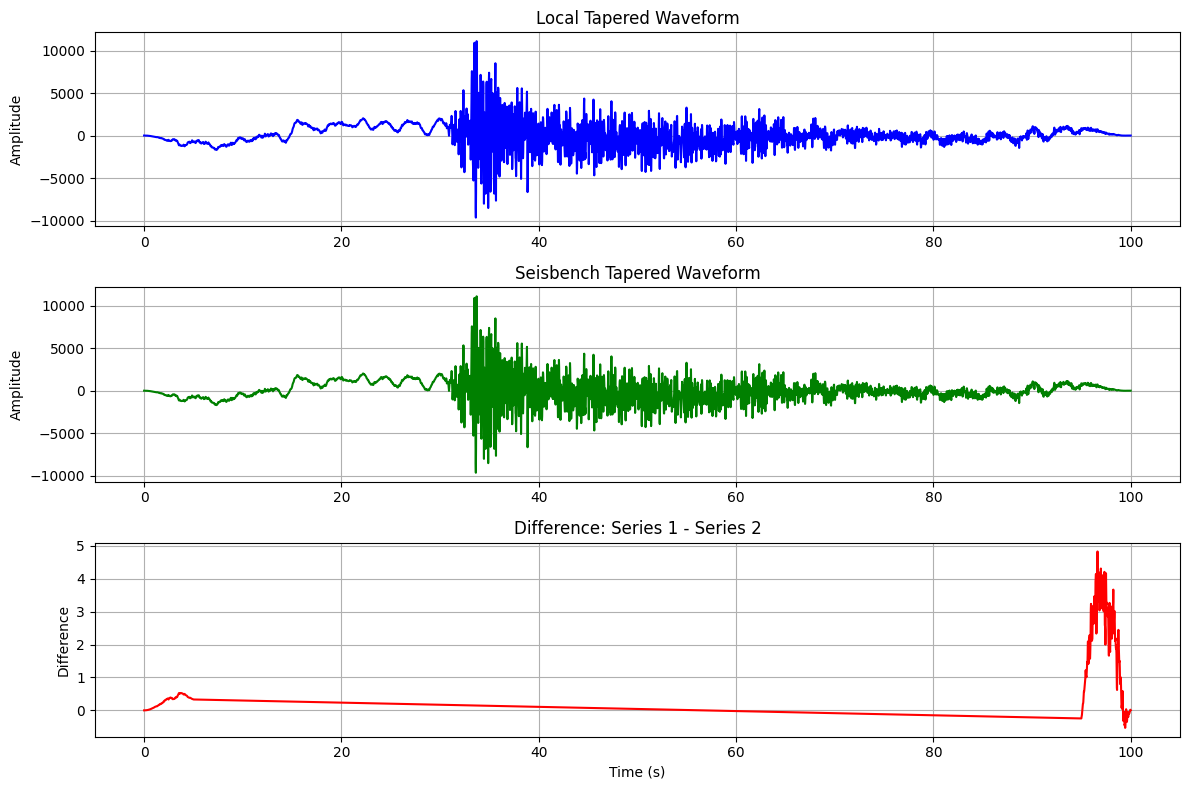

In [141]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = tapered_data[0][:5000]
series2 = tapered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


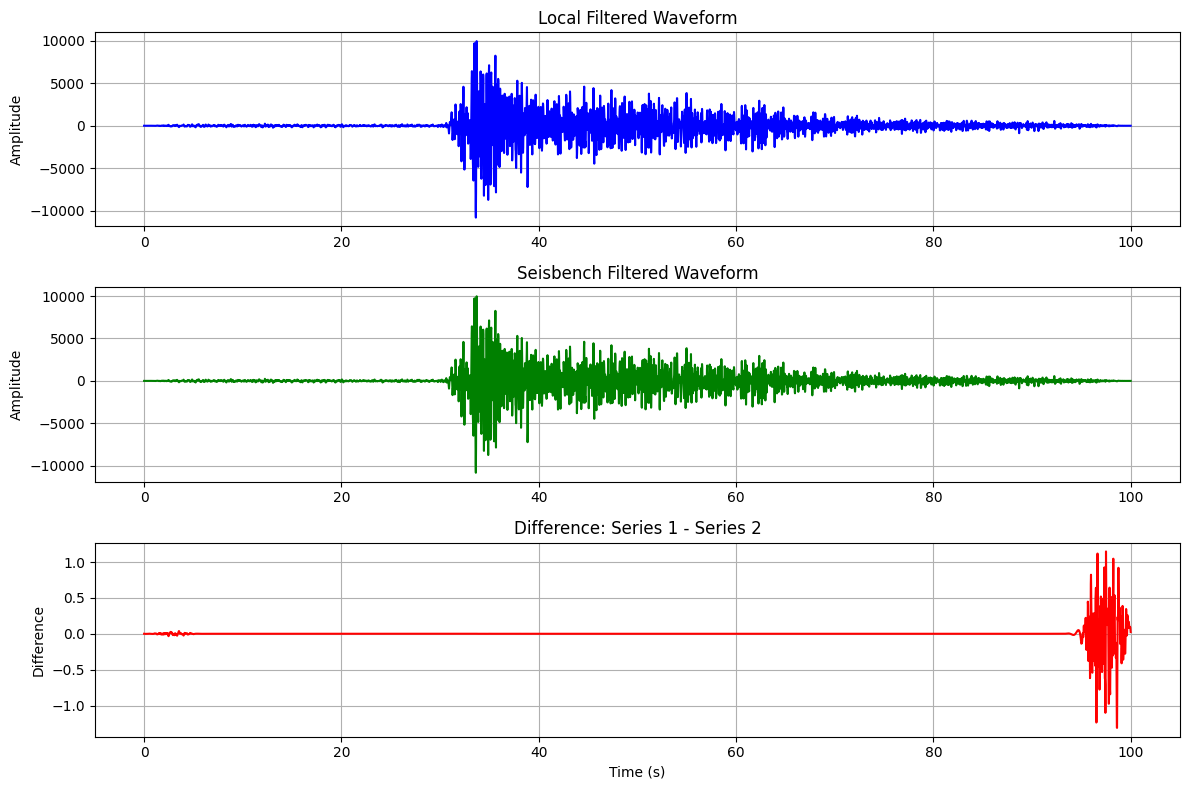

In [142]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = resampled_data[0][0][:5000]
series2 = filtered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


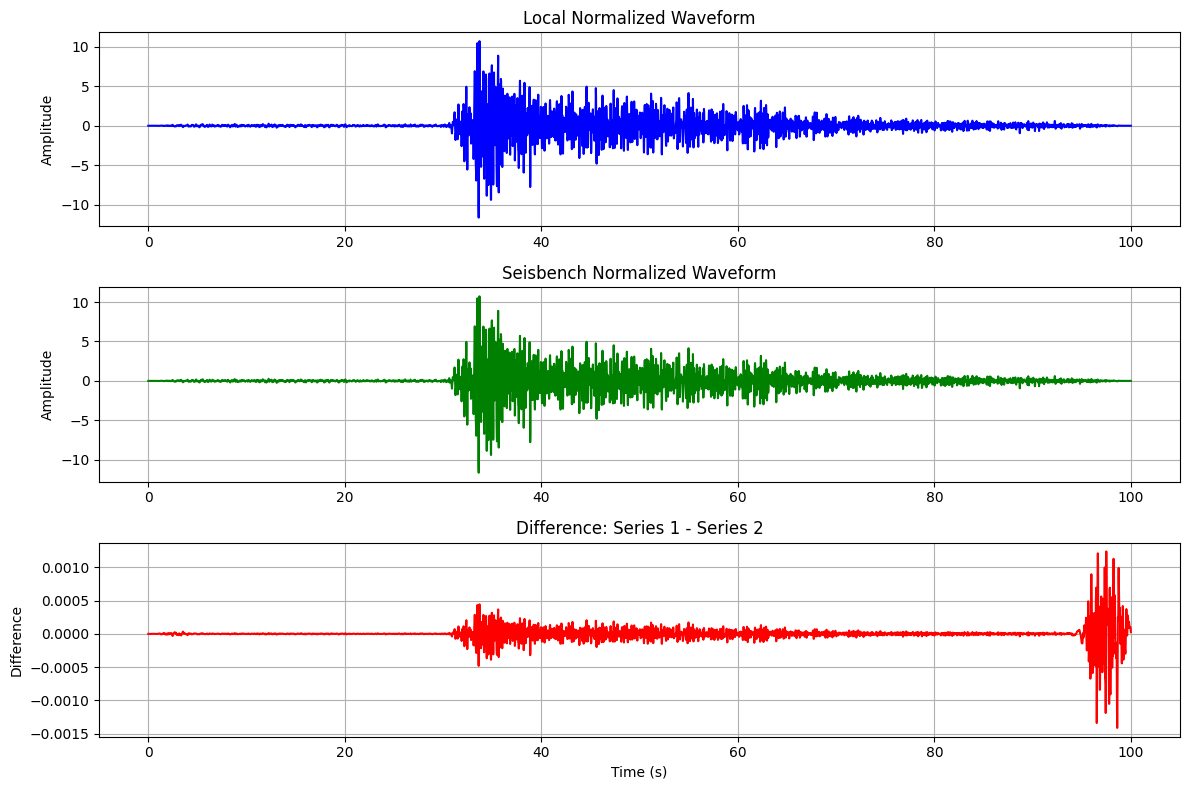

In [143]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = norm[0][0][:5000]
series2 = norm_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


In [144]:
from helper_functions import extract_spectrograms
help(extract_spectrograms)

Help on function extract_spectrograms in module helper_functions:

extract_spectrograms(waveforms=[], fs=50, nperseg=256, overlap=0.5, print_shape=False)



100%|██████████| 1/1 [00:00<00:00, 1082.12it/s]


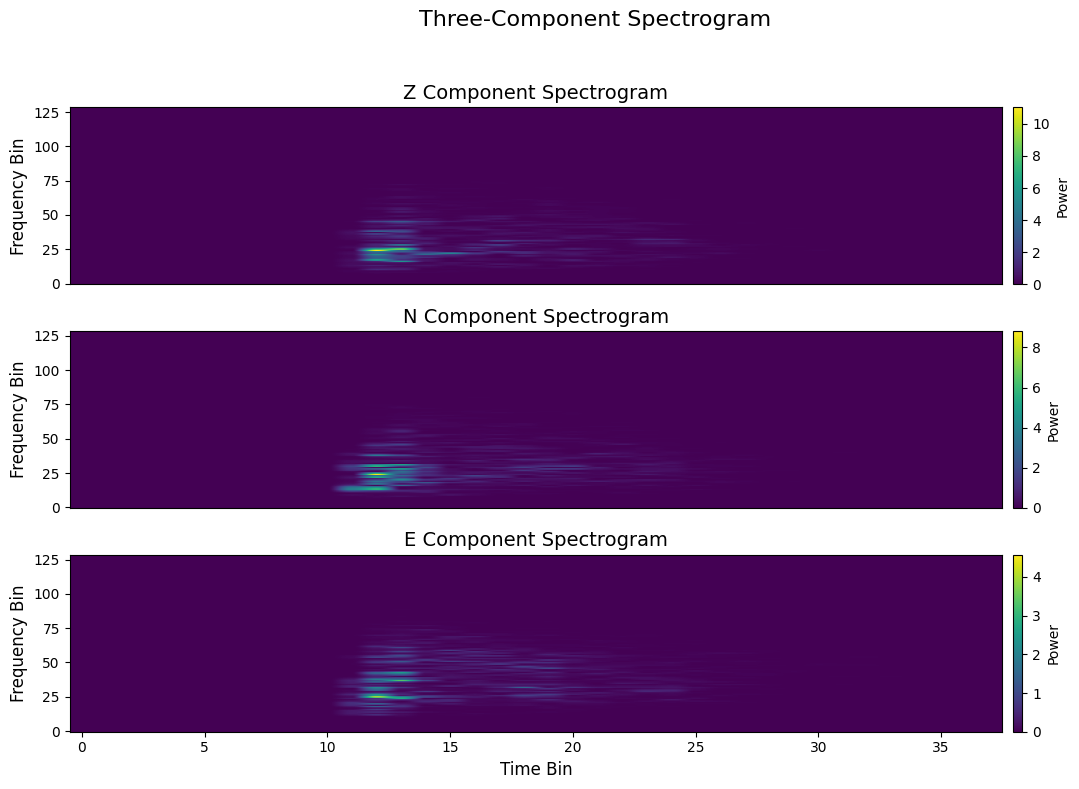

In [145]:
nperseg=256
overlap=0.5
fs = 50
noverlap = int(nperseg * overlap)  # Calculate overlap
f, t, _ = signal.spectrogram(norm, nperseg=nperseg, noverlap=noverlap, fs=fs)

spec_local = extract_spectrograms(norm)


# Assume `spectrogram` has shape (1, 3, 129, 38)
# spectrogram = your_spectrogram_array
# f, t = frequencies and times from signal.spectrogram

components = ['Z', 'N', 'E']
spec = spec_local[0]  # Remove batch dimension, now shape (3, 129, 38)

# Assume `spectrogram` is a torch.Tensor of shape (1, 3, 129, 38)
spec = spec_local[0] # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(spec[i], aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{components[i]} Component Spectrogram", fontsize=14)
    plt.ylabel("Frequency Bin", fontsize=12)
    plt.colorbar(label='Power', pad=0.01)
    if i == 2:
        plt.xlabel("Time Bin", fontsize=12)
    else:
        plt.xticks([])

plt.suptitle("Three-Component Spectrogram", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [259]:
def extract_spectrograms(waveforms = a, fs = fs, nperseg=256, overlap=0.5, print_shape = False):
    noverlap = int(nperseg * overlap)  # Calculate overlap

    # Example of how to get the shape of one spectrogram
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize an array of zeros with the shape: (number of waveforms, channels, frequencies, time_segments)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Fill the pre-initialized array

    if print_shape:
        print(spectrograms.shape)
    return spectrograms





def extract_spectrograms_pytorch(waveforms, fs, nperseg=256, overlap=0.5):
    """
    Extract spectrograms, time segments, and frequency bins from waveforms.

    Parameters:
        waveforms: Tensor of shape (n_waveforms, n_channels, n_samples)
        fs: Sampling rate (Hz)
        nperseg: Number of FFT points
        overlap: Fractional overlap between segments

    Returns:
        spectrograms: Tensor of shape (n_waveforms, n_channels, frequencies, time_segments)
        frequencies: Array of frequency bins (Hz)
        time_segments: Array of time segment centers (seconds)
    """
    noverlap = int(nperseg * overlap)  # Calculate overlap
    hop_length = nperseg - noverlap  # Calculate hop length

    # Compute frequencies
    frequencies = torch.fft.rfftfreq(nperseg, d=1/fs)

    # Compute time segments
    time_segments = torch.arange(0, waveforms.shape[-1] - nperseg + 1, hop_length) / fs
    
    window = torch.hann_window(nperseg, device=waveforms.device)


    # Example spectrogram to get dimensions
    example_spectrogram = torch.stft(
        waveforms[0, 0], n_fft=nperseg, window = window, hop_length=hop_length, win_length=nperseg, 
        return_complex=True, center=False, normalized = False
    )
    freq_bins, time_bins = example_spectrogram.shape[-2], example_spectrogram.shape[-1]

    # Initialize tensor for spectrograms
    spectrograms = torch.zeros(
        (waveforms.shape[0], waveforms.shape[1], freq_bins, time_bins), dtype=torch.complex64
    )

    # Compute spectrograms
    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            Sxx = torch.stft(
                waveforms[i, j], n_fft=nperseg, hop_length=hop_length, win_length=nperseg, window = window,  
                return_complex=True, center=False, normalized= False,
            )
            spectrograms[i, j] = Sxx  # Fill the tensor

    # Convert complex spectrogram to magnitude
    spectrograms = torch.abs(spectrograms)**(2)

    return spectrograms, frequencies, time_segments




def extract_spectrograms_torch_matched(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, device=waveforms.device)
    frequencies = torch.fft.rfftfreq(nperseg, d=1/fs)
    time_segments = torch.arange(0, waveforms.shape[-1] - nperseg + 1, hop_length) / fs

    # Example to get shape
    example_spec = torch.stft(
        waveforms[0, 0], n_fft=nperseg, hop_length=hop_length, win_length=nperseg,
        return_complex=True, window=window, center=False, normalized= True
    )
    freq_bins, time_bins = example_spec.shape[-2], example_spec.shape[-1]

    spectrograms = torch.zeros(
        (waveforms.shape[0], waveforms.shape[1], freq_bins, time_bins),
        dtype=torch.complex64, device=waveforms.device
    )

    for i in range(waveforms.shape[0]):
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j], n_fft=nperseg, hop_length=hop_length, win_length=nperseg,
                return_complex=True, window=window, center=False, normalized= True
            )
            spectrograms[i, j] = Sxx

    power = torch.abs(spectrograms)**2
    return power, frequencies, time_segments



def extract_spectrograms_torch_matched_new(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, dtype=waveforms.dtype, device=waveforms.device)
    window_energy = window.pow(1).sum()

    spec = []
    for i in range(waveforms.shape[0]):
        comps = []
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j],
                n_fft=nperseg,
                hop_length=hop_length,
                win_length=nperseg,
                window=window,
                center=False,
                return_complex=True,
                normalized= False,  # better match
            )
            power = torch.abs(Sxx)**2/window_energy  # 🔥 critical step
            comps.append(power)
        spec.append(torch.stack(comps))

    return torch.stack(spec)  # shape: (B, 3, F, T)



def spectrogram_torch_scipy_match(x, fs, nperseg=256, overlap=0.5):
    """
    x : (B, C, N)  PyTorch tensor   (batch, channels, samples)
    returns PSD  : (B, C, F, T)
    """
    B, C, N   = x.shape
    noverlap  = int(nperseg * overlap)
    hop       = nperseg - noverlap
    window    = torch.hann_window(nperseg, dtype=x.dtype, device=x.device)

    # 1. mimic SciPy's default detrend='constant'
    x = x - x.mean(dim=-1, keepdim=True)

    # 2. flatten to 2-D:  (B*C, N)
    x2 = x.reshape(B * C, N)

    # 3. STFT
    Z = torch.stft(
        x2,
        n_fft         = nperseg,
        hop_length    = hop,
        win_length    = nperseg,
        window        = window,
        center        = False,        # pads like SciPy
        return_complex=True,
        normalized    = False,       # no extra 1/√N factor
    )                                # ⇒ shape (B*C, F, T)

    # 4. reshape back to (B, C, F, T)
    Z = Z.view(B, C, *Z.shape[-2:])  # (B, C, F, T)

    # 5. power spectral density |Z|² / (Σ w² · fs)
    W   = window.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)

    # ---- NEW: match SciPy's one-sided rescaling -------------------
    if nperseg % 2 == 0:                  # even n_fft  → has Nyquist bin
        psd[..., 1:-1, :] *= 2.0          # skip DC (0) and Nyquist (-1)
    else:                                 # odd n_fft → no Nyquist bin
        psd[..., 1:, :]   *= 2.0          # skip DC only
        
    return psd                      # (B, C, F, T)



In [260]:
# Convert the processed waveforms to spectrograms
spec_torch = spectrogram_torch_scipy_match(torch.Tensor(norm).to(device), fs = 50)

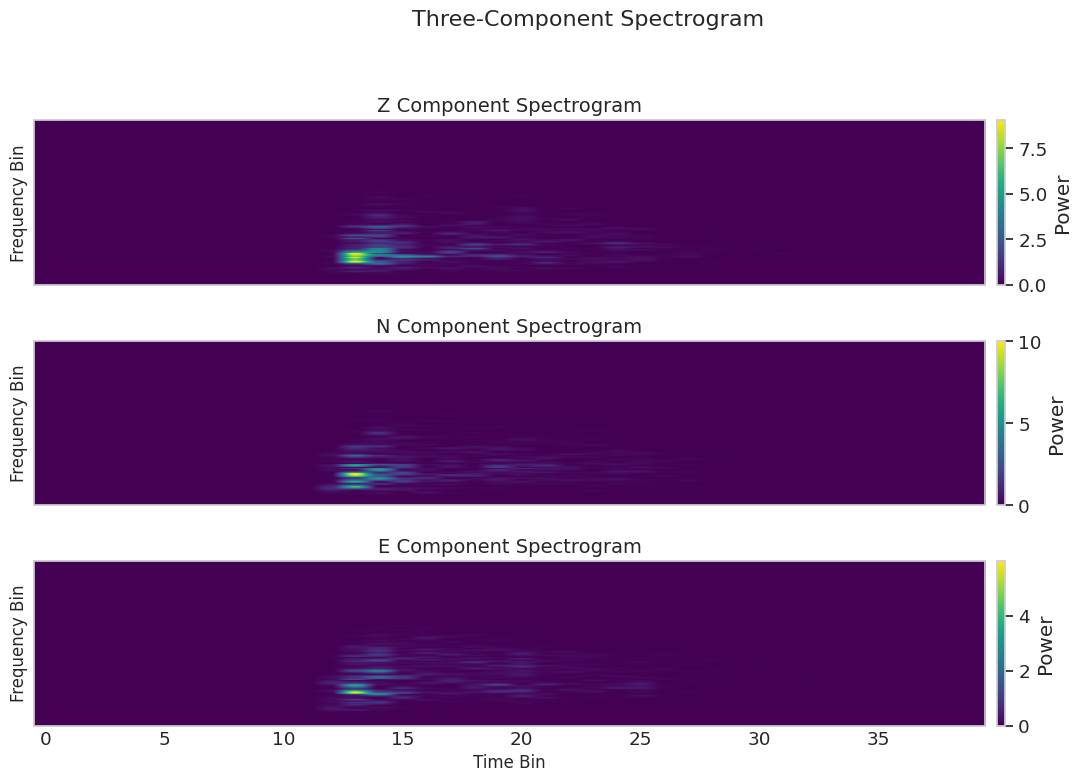

In [261]:
components = ['Z', 'N', 'E']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


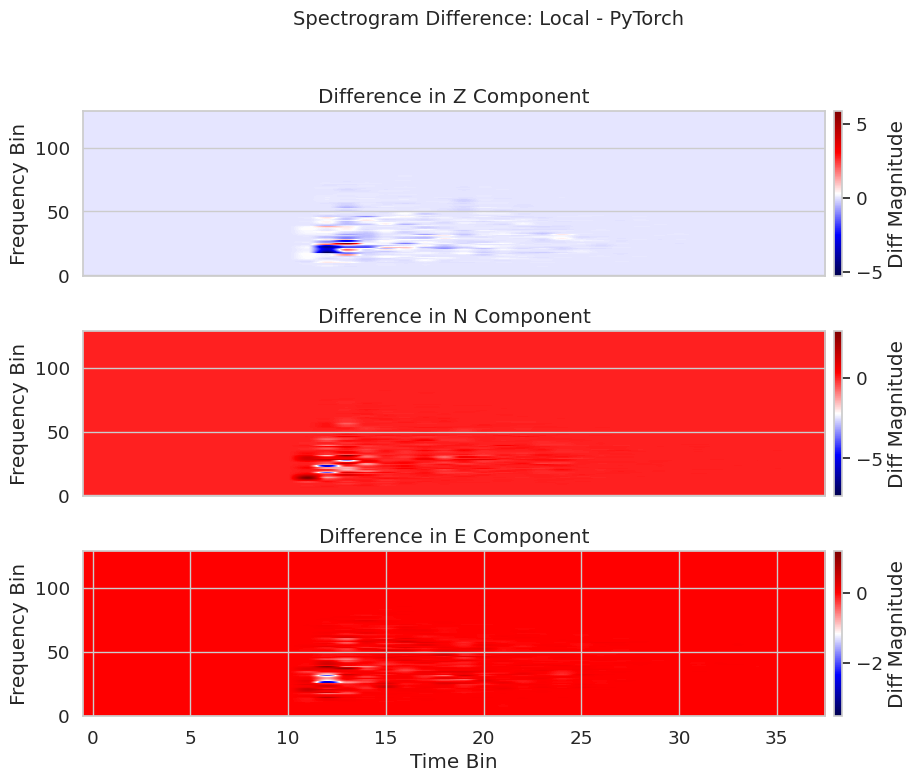

In [262]:
# Assume these are torch.Tensors, convert to numpy arrays
diff = (spec_local - spec_torch.numpy())[0] # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(diff[i], aspect='auto', origin='lower', cmap='seismic')
    plt.title(f"Difference in {components[i]} Component")
    plt.ylabel("Frequency Bin")
    if i == 2:
        plt.xlabel("Time Bin")
    else:
        plt.xticks([])
    plt.colorbar(label='Diff Magnitude', pad=0.01)

plt.suptitle("Spectrogram Difference: Local - PyTorch", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Testing the old, new, and local implementation on all of the events in the catalog. 

## Old seisbench version 

In [118]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs = []
seisbench_event_ids = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        

        # Normalize each component by the standard deviation of their absolute values
        batch_abs = torch.abs(batch)
        std_abs = batch_abs.std(dim=-1, keepdim=True)
        norm_batch = batch / (std_abs + 1e-10)  # Avoid division by zero

        
        #batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = extract_spectrograms_pytorch(batch, fs=sample_rate)
        

        # Run model
        inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs.append(probs.cpu())
        seisbench_event_ids.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/1605 [00:00<?, ?it/s]/tmp/ipykernel_3776147/3676733169.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
Processing events:  52%|█████▏    | 840/1605 [07:47<07:07,  1.79it/s]/tmp/ipykernel_3776147/3676733169.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  52%|█████▏    | 841/1605 [07:47<06:53,  1.85it/s]

Failed to process event pnsn1802943: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  96%|█████████▌| 1535/1605 [14:31<00:38,  1.84it/s]

Failed to process event pnsn1465473: cannot reshape array of size 5000 into shape (1,3,5000)


Processing events: 100%|██████████| 1605/1605 [15:14<00:00,  1.75it/s]


# New Seisbench version

In [ ]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs_new = []
seisbench_event_ids_new = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = spectrogram_torch_scipy_match(batch, fs=sample_rate)

        # Run model
        inputs = torch.tensor(spec, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs_new.append(probs.cpu())
        seisbench_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/1605 [00:00<?, ?it/s]/tmp/ipykernel_3776147/1809089973.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec, dtype=torch.float32).to(device)
Processing events:  52%|█████▏    | 840/1605 [08:46<09:03,  1.41it/s]/tmp/ipykernel_3776147/1809089973.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  52%|█████▏    | 841/1605 [08:47<08:19,  1.53it/s]

Failed to process event pnsn1802943: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  59%|█████▉    | 944/1605 [09:51<06:18,  1.75it/s]

## Local implementation

In [120]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
local_probs_new = []
local_event_ids_new = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        stream.detrend('linear')
        
        # Resample to 50 Hz
        stream.resample(sample_rate)

        # event data
        event_data = np.array(s)

        # tapering before filtering
        taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
        tapered_data = np.array([np.multiply(taper, row) for row in event_data])

        
        #Apply bandpass filtering
        filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





        # resampling and normalizing 
        num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
        resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

        resampled_data = resampled_data[:,0:5000]
        resampled_data = resampled_data.reshape(1,3, 5000)

        mmax = np.std(np.abs(resampled_data[0]))
        norm = resampled_data/mmax


        spec_local = extract_spectrograms(norm)
    
        # Run model
        inputs = torch.tensor(spec_local, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        local_probs_new.append(probs.cpu())
        local_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events: 100%|██████████| 1605/1605 [15:48<00:00,  1.69it/s]


In [122]:
len(local_probs_new)

1605

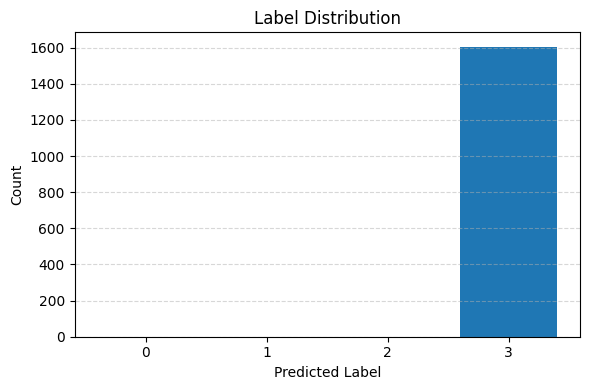

In [130]:
# Your list of tensors
probs_list = local_probs_new

# Step 1: Get predicted labels
labels_local = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_local, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


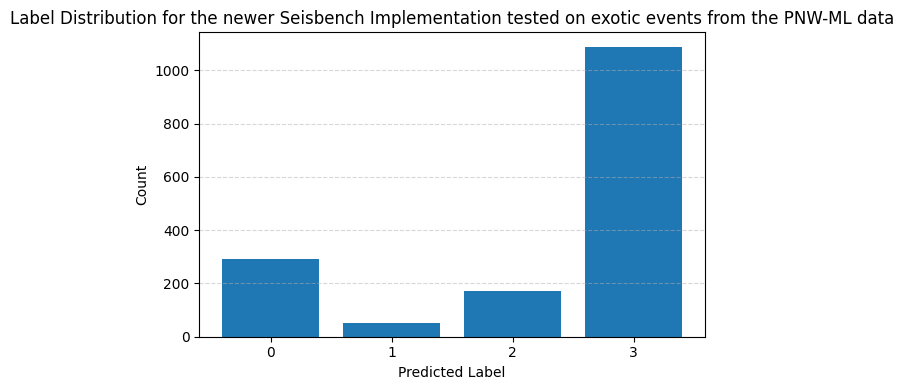

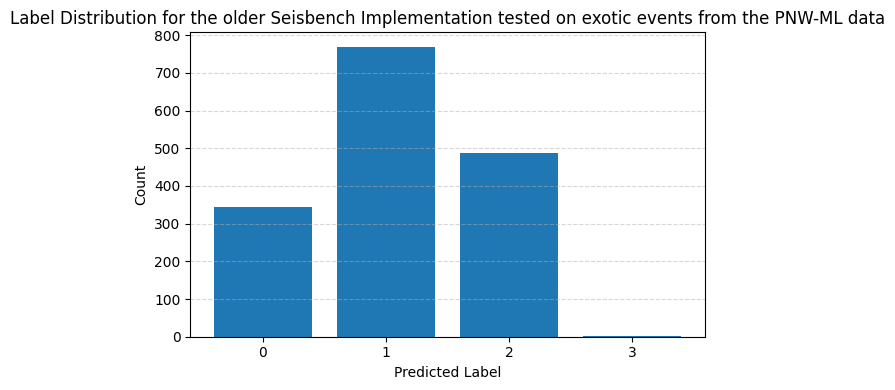

In [175]:
# Your list of tensors
probs_list = seisbench_probs_new
# Step 1: Get predicted labels
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_new, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the newer Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Your list of tensors
probs_list = seisbench_probs
# Step 1: Get predicted labels
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_old, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the older Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

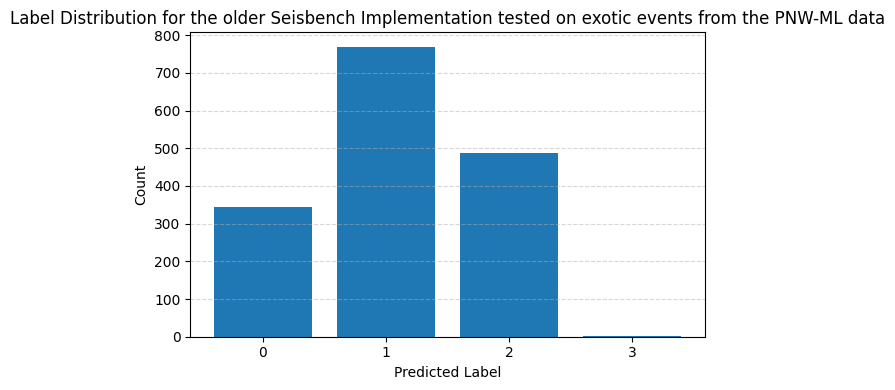

[3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 3,
 0,
 3,
 3,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [135]:
local_event_ids_new

['pnsn3179093',
 'pnsn3179088',
 'pnsn3177563',
 'pnsn3177488',
 'pnsn3177373',
 'pnsn3177368',
 'pnsn3177363',
 'pnsn3176813',
 'pnsn3176848',
 'pnsn3179443',
 'pnsn3175703',
 'pnsn3173148',
 'pnsn3175953',
 'pnsn3175948',
 'pnsn3175723',
 'pnsn3175648',
 'pnsn3175648',
 'pnsn3175668',
 'pnsn3175683',
 'pnsn3175508',
 'pnsn3175498',
 'pnsn3174978',
 'pnsn3174798',
 'pnsn3174648',
 'pnsn3174803',
 'pnsn3174803',
 'pnsn3174803',
 'pnsn3174533',
 'pnsn3174533',
 'pnsn3171513',
 'pnsn3171563',
 'pnsn3174173',
 'pnsn3171248',
 'pnsn3171388',
 'pnsn3170843',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170748',
 'pnsn3170713',
 'pnsn3170673',
 'pnsn3170663',
 'pnsn3170653',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3173138',
 'pnsn3173128',
 'pnsn3170503',
 'pnsn3173023',
 'pnsn3170383',
 'pnsn3172058',
 'pnsn3172058',
 'pnsn3172058',
 'pnsn3172133',
 'pnsn3171833',
 'pnsn3171783',
 'pnsn31

In [158]:
import numpy as np
import torch
from scipy import signal

# Matching parameters
fs = 100
nperseg = 256
overlap = 0.5
noverlap = int(nperseg * overlap)
hop_length = nperseg - noverlap

# Create dummy waveform data similar to (B, C, T)
np.random.seed(0)
wave_np = np.random.randn(2, 3, 2048).astype(np.float32)
wave_torch = torch.tensor(wave_np)

# Scipy version
def extract_spectrograms_scipy(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):
        for j in range(waveforms.shape[1]):
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs, scaling='density', mode='psd')
            spectrograms[i, j] = Sxx

    return spectrograms

# PyTorch version (modified)
def extract_spectrograms_torch(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, dtype=waveforms.dtype, device=waveforms.device)
    spec = []
    for i in range(waveforms.shape[0]):
        comps = []
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j],
                n_fft=nperseg,
                hop_length=hop_length,
                win_length=nperseg,
                window=window,
                center=False,
                return_complex=True,
                normalized=False,
            )
            power = (torch.abs(Sxx) ** 2) / (fs * (window ** 2).sum())
            comps.append(power)
        spec.append(torch.stack(comps))
    return torch.stack(spec).numpy()

# Run both versions
spec_scipy = extract_spectrograms_scipy(wave_np, fs, nperseg, overlap)
spec_torch = extract_spectrograms_torch(wave_torch, fs, nperseg, overlap)

# Compare numerically
difference = np.abs(spec_scipy - spec_torch).mean()
difference_max = np.abs(spec_scipy - spec_torch).max()

difference, difference_max


(0.01094126606634296, 0.11320343613624573)

/tmp/ipykernel_3776147/2598936444.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


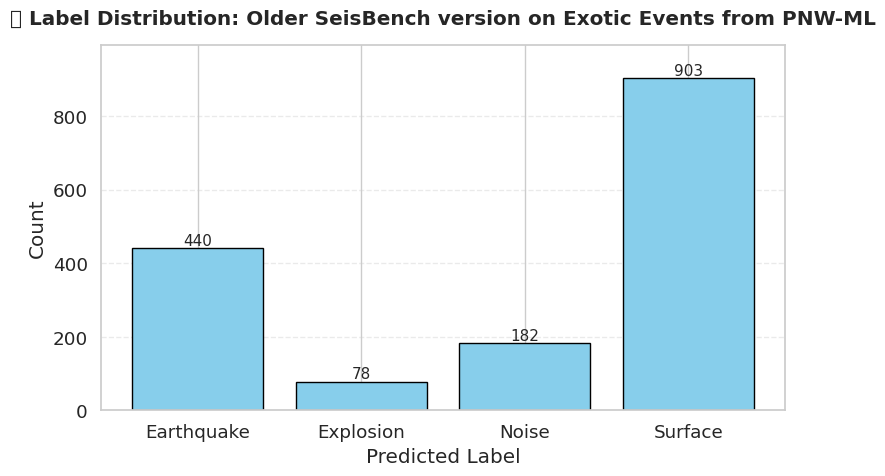

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assume probs_list is already defined
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_old.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: Older SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_3776147/1155447537.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


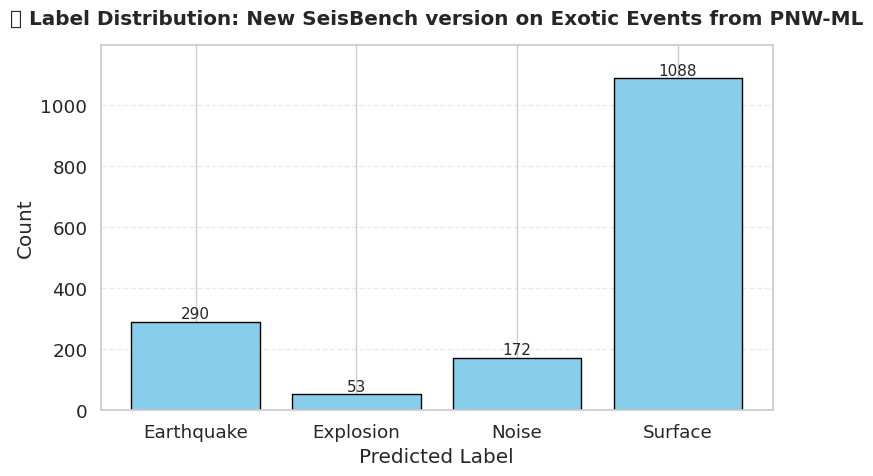

In [194]:
probs_list = seisbench_probs_new

# Assume probs_list is already defined
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_new.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: New SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()

